## 3η Εργαστηριακή Άσκηση στα Νευρωνικά Δίκτυα

### Ομάδα 7

- Γεώργιος Αλεξανδρής (03118195)
- Ναταλία-Μαρία Γρηγοριάδου (03118940)
- Στεφανία Σκόρδα (03118852)

Username στον διαγωνισμό : skou

## Setup

In [1]:
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/libnvvp")
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/extras/CUPTI/lib64")

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/extras/CUPTI/lib64')>

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# session.close()

This tutorial uses lots of imports, mostly for loading the dataset(s).

In [4]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

from nltk.translate import bleu_score

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
import joblib

In [5]:
tf.config.run_functions_eagerly(False)

In [6]:
# print(tf.config.list_physical_devices('GPU'))

## Data handling

Εισαγωγή εικόνων από το Flickr8k και το Flickr30k και δημιουργία των train test path και έπειτα των αρχείων.

In [8]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

In [9]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# cut the train files list
# train_files_list = train_files_list[:len(train_files_list)//2]

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

## Προεπεξεργασία δεδομένων


In [10]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text(encoding='utf8').splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

fname_new = []
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
    cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
 
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
   
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

## Ιστόγραμμα μήκους προτάσεων
Προκειμένου να βελτιστοποιήσουμε το μοντέλο μας, εκτυπώνουμε ένα ιστόγραμμα μήκους προτάσεων. Αυτό μας δίνει μια ιδέα για το ποια είναι τα άνω και κάτω όρια των μηκών των captions του dataset μας. Έπειτα από δοκιμές επιλέξαμε να κρατήσουμε μόνο τις προτάσεις με μήκος μεταξύ 3 και 30 λέξεων.

In [11]:
def word_cnt(s):
    return len(s.split())

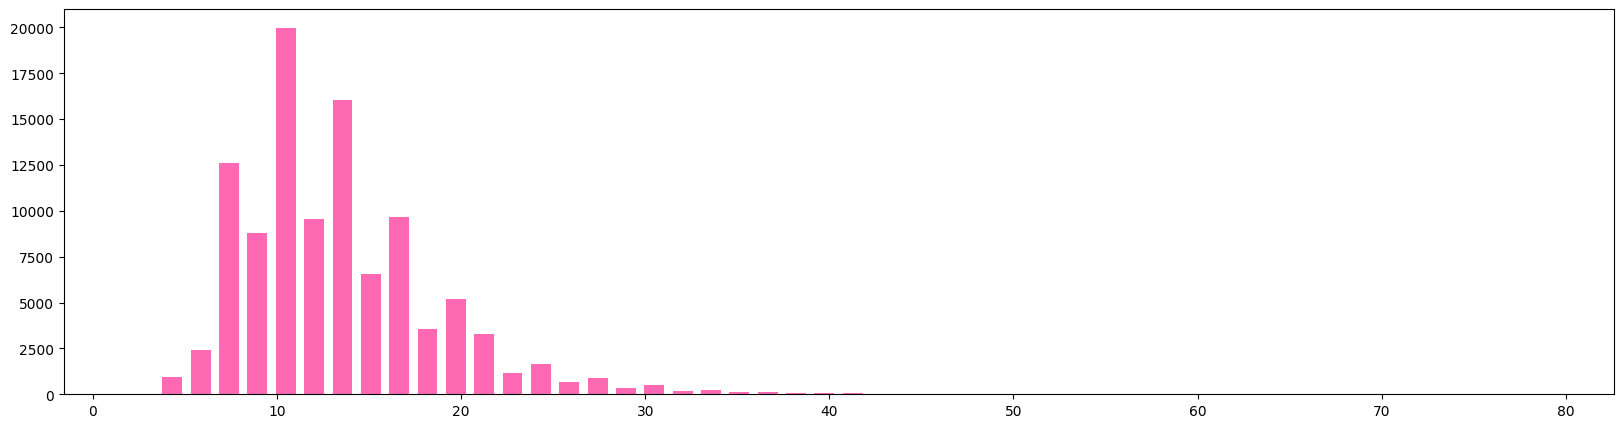

In [12]:
lengths = []

for cap in train_captions:
    for i in cap[1]:
        lengths.append(word_cnt(i))

plt.figure(figsize=(20,5))
plt.hist(lengths, bins=50,rwidth=0.7,color="hotpink")
# plt.xlim(0,25)
# plt.xticks()
plt.show()

Προκειμένου να βελτιστοποιήσουμε το μοντέλο μας 

In [13]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text(encoding='utf8').splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

fname_new = []
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
    cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = []
for fname in train_files:
    flag=True
    for i in range(5):
        if (len(cap_dict[fname][i].split())) < 3 or (len(cap_dict[fname][i].split()) > 30):
            flag=False
            break
    if flag:
        train_captions.append((str(path/IMAGE_DIR/fname), cap_dict[fname]) ) 



 
test_files = (path/test_files_list).read_text().splitlines()
test_captions = []
for fname in test_files:
    flag=True
    for i in range(5):
        if len(cap_dict[fname][i].split()) < 3 or len(cap_dict[fname][i].split()) > 30:
            flag=False
            break
    if flag:
        test_captions.append((str(path/IMAGE_DIR/fname), cap_dict[fname]))
   
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k dataset contains 5 captions per image, while Conceptual Captions has 1:

In [14]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [15]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir\\_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


### Image feature extractor

* Τα μοντέλα που χρησιμοποιήσαμε για την εκπαίδευση του μοντέλου μας φαίνονται παρακάτω. Παρατηρήσαμε ότι η επιλογή των feature extractor (με κατάλληλη επιλογή των παραμέτρων) εμφανίζει πολύ μικρές αλλαγές στην απόδοση του μοντέλου μας. Το μοντέλο που έβγαλε το καλύτερο αποτέλεσμα είναι το Xception.

In [16]:
IMAGE_SHAPE=(224, 224, 3)
# best so far
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True,
    )
mobilenet.trainable=False

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
# best so far
mobilenet = tf.keras.applications.MobileNetV3Large(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True,
    )
mobilenet.trainable=False

In [17]:
IMAGE_SHAPE = (299,299,3)

xception = tf.keras.applications.Xception(
    input_shape=IMAGE_SHAPE,
    include_top=False
)
xception.trainable=False

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
vgg16 = tf.keras.applications.VGG16(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    )
vgg16.trainable=False

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
vgg19 = tf.keras.applications.VGG19(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    )
vgg19.trainable=False

In [ ]:
efficientnet = tf.keras.applications.EfficientNetB7(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    )
efficientnet.trainable=False

Here's a function to load an image and resize it for the model:

In [19]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [20]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)

(1, 299, 299, 3)


### Δημιουργία tokenizer/vectorizer


In [21]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  # remove punctuation   
  s = tf.strings.regex_replace(s, '[^a-zA-Z0-9\s]', '')

  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [22]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [23]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [24]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'man', 'and']

In [25]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 779, 5, 2, 64, 4], [3, 2, 2717, 29, 4]]>

In [26]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [27]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [28]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Δημιουργία των datasets

In [29]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [30]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


### Δημιουργία Tensor Dataset από τα δεδομένα

In [31]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [32]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):

  

  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):   
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

### Caption length plotting

In [33]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [34]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Cache των image features

In [35]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
       
      images = tf.keras.applications.xception.preprocess_input(images)
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [36]:
save_dataset(train_raw, 'train_cache', xception, tokenizer,batch_size=32)
save_dataset(test_raw, 'test_cache', xception, tokenizer,batch_size=32)

618it [02:30,  4.10it/s]
134it [00:31,  4.19it/s]


 </section>


## Φόρτωση των caches αρχείων και προετοιμασία εκτέλεσης.

In [37]:
train_ds = load_dataset('train_cache', batch_size=32)
test_ds = load_dataset('test_cache', batch_size=32)

In [38]:
train_ds.element_spec

((TensorSpec(shape=(None, 10, 10, 2048), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [39]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 10, 10, 2048)
(32, 27)
(32, 27)


Εκτύπωση label και tokens τα οποία είναι shifted κατά μία θέση.

In [40]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  13  12 184 110  20   2 700  10  32   7   2  84   0   0   0   0
   0   0   0   0   0   0   0   0   0]
[  2  13  12 184 110  20   2 700  10  32   7   2  84   4   0   0   0   0
   0   0   0   0   0   0   0   0   0]


## Το δοσμένο Transformer decoder model

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

## Our Embedding Implementation

Για την υλοποίηση των δικών μας embedding η καλύτερη επιλογή ήταν η επιλογή του ```glove-wiki-gigaword-300```

In [43]:
import gensim.downloader as api

for i in list(api.info()['models'].keys()):
    print(i)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [44]:
embed_model = api.load('glove-wiki-gigaword-300')

In [45]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for idx, word in enumerate(tokenizer.get_vocabulary()):
    try:
        embedding_vector = embed_model[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[idx] = vec
     

In [46]:
embedding_matrix.shape

(10000, 300)

### Δοσμένο Input Layer

In [47]:
class SeqEmbedding(tf.keras.layers.Layer):

  def __init__(self, vocab_size, max_length, depth,ourembedding=False):
    super().__init__()


    if(ourembedding):
      self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=EMBEDDING_DIM)
      self.token_embedding = tf.keras.layers.Embedding(vocabulary_size,
                                               EMBEDDING_DIM,
                                               weights=[embedding_matrix],
                                               trainable=False)  
    else:
      self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
      self.token_embedding = tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=depth,
          mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)



    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth) 
    

    return self.add([seq,x])


### Δοσμένο Decoder

### CasualSelfAttention Layer

In [48]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


### CrossAttention Layer

* Στην παραπάνω συνάρτηση, η έξοδός του εξαρτάται από το διάνυσμα του embedding που έχουμε ορίσει. Προκειμένου να την ανεξαρτητοποιήσουμε προσθέτουμε ένα Fully Connected layer με έξοδο διάνυσμα σταθερής διάστασης. Έτσι η έξοδος μας εξαρτάται πλέον από την διάσταση που ορίζουμε εμείς με την παράμετρο units. 

In [49]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.dense = tf.keras.layers.Dense(512)
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])

    x = self.dense(x)

  

    return self.layernorm(x)

### Δοσμένο Feed Forward Layer 

- Στην δική μας υλοποίηση τα καλύτερα αποτελέσματα προέκυψαν με την χρήση μόνο ενός πλήρως συνδεδεμένου στρώματος με συνάρτηση ενεργοποίησης ReLU.

In [50]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=units,activation='relu'),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])      
    
        
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
  
    x = x + self.seq(x)
    
    return self.layernorm(x)


### Δοσμένο Decoder Layer

In [51]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)


    return out_seq

### Δοσμένο Output Layer

In [52]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


### Προσαρμογή στρώματος εξόδου

In [53]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 3087/3087 [03:04<00:00, 16.71it/s]


Uniform entropy: 9.21
Marginal entropy: 5.57


### Δοσμένη συνάρτηση του μοντέλου

In [54]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1,ourembedding = False):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length*2,
        ourembedding = ourembedding)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [55]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs
  
  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = tf.keras.applications.xception.preprocess_input(image)
    image = self.feature_extractor(image)
  
  
  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')
  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)
  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))

  txt = self.output_layer(txt)

  return txt

#### Βέλτιστες παραμέτροι εκπαίδευσης

- 512 μονάδες-διάνυσμα εξόδου
- Ρυθμός διαγραφής δεδομένων 0.3
- 4 layers - 4 heads
- 0.0001 learning rate
- 32 batch size
- 20 εποχές εκπαίδευσης

In [56]:
model = Captioner(tokenizer, feature_extractor=xception, output_layer=output_layer,
                  units=512, dropout_rate=0.3, num_layers=4, num_heads=4,ourembedding = True)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [57]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

### Υλοποίηση Beam Search και simple_gen του δοσμένου μοντέλου

In [58]:
def beam_search_predictions(captioner,img_features,tokens, beam_index = 3):
    start = [word_to_index('[START]')]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < 50:
        temp = []
        for s in start_word:

            
            ### CAPTIONER ###
            preds = captioner((img_features, np.array([s[0]]))).numpy()
            #################
            preds = preds[:,-1, :]  #(batch, vocab)
        
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [index_to_word(i) for i in start_word]

    final_caption = []

    
    for i in intermediate_caption:
        i = i.numpy().decode("utf-8")
        if i != '[END]':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [59]:
@Captioner.add_method
def simple_gen(self, image, temperature=1, beam_size=0):


  image = tf.keras.applications.xception.preprocess_input(image)
  
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])


  tokens = initial # (batch, sequence)
  if beam_size > 0:
    result = beam_search_predictions(self,img_features,tokens, beam_index = beam_size)

  else:
    for n in range(50):
      preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)

      preds = preds[:,-1, :]  #(batch, vocab)
      if temperature==0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
      else:
          next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

      if next[0] == self.word_to_index('[END]'):
        break
  
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ').numpy().decode()
  return result

### Δοκιμαστικές Προβλέψεις

In [60]:
result = model.simple_gen(image, temperature=0.0,beam_size=0)
print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


In [61]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t, beam_size=0)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a
shirt caught building diving across his they in musical several a elderly person up a stick


## Train

### Μετρικές και Συνάρτηση Κόστους

In [65]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc


### Δοσμένα Callbacks

In [66]:
class GenerateText(tf.keras.callbacks.Callback):
  beam = False
  def __init__(self,b=False):
    self.beam = b
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    if(not self.beam):
      for t in (0.0, 0.5, 1.0):
        result = self.model.simple_gen(self.image, temperature=t)
    else:
      result = self.model.simple_gen(self.image, beam_size=3)

    print(result)
    print()


Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [67]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [69]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=200,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=20,
    callbacks=callbacks)

Epoch 1/20
200/200 [==============================] - 30s 118ms/step - loss: 4.8022 - masked_acc: 0.2545 - val_loss: 4.4474 - val_masked_acc: 0.2863
Epoch 2/20
200/200 [==============================] - 22s 110ms/step - loss: 4.3329 - masked_acc: 0.2975 - val_loss: 4.1666 - val_masked_acc: 0.3040
Epoch 3/20
200/200 [==============================] - 22s 112ms/step - loss: 4.1513 - masked_acc: 0.3101 - val_loss: 3.9831 - val_masked_acc: 0.3167
Epoch 4/20
200/200 [==============================] - 22s 112ms/step - loss: 3.9877 - masked_acc: 0.3211 - val_loss: 3.8614 - val_masked_acc: 0.3264
Epoch 5/20
200/200 [==============================] - 22s 112ms/step - loss: 3.8733 - masked_acc: 0.3299 - val_loss: 3.7750 - val_masked_acc: 0.3330
Epoch 6/20
200/200 [==============================] - 22s 112ms/step - loss: 3.7660 - masked_acc: 0.3365 - val_loss: 3.6567 - val_masked_acc: 0.3453
Epoch 7/20
200/200 [==============================] - 23s 114ms/step - loss: 3.6926 - masked_acc: 0.3423 -

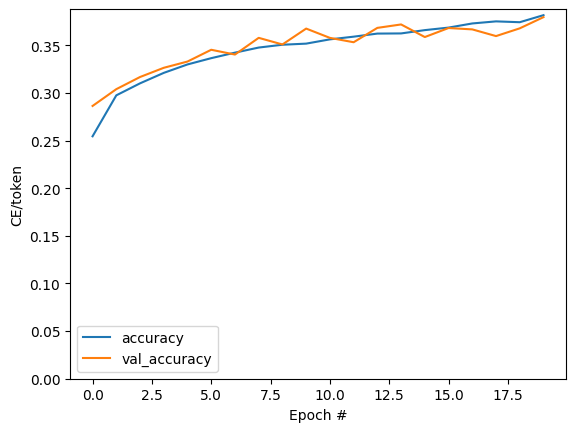

In [70]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.show()


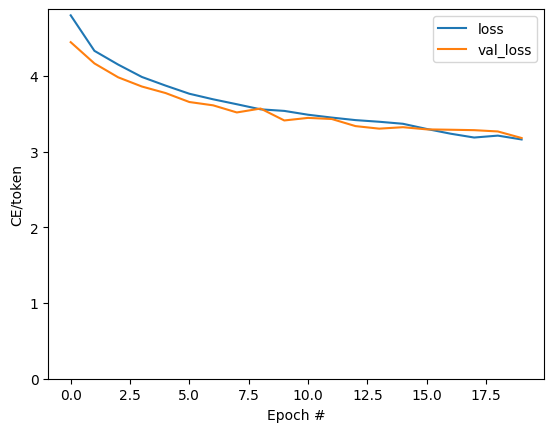

In [71]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()
plt.show()

## Attention plots

### Παράδειγμα κακής εκτέλεσης με Temperature = 1

In [72]:
result = model.simple_gen(image, beam_size=0)
result

'a man in a bikini prepares to play in the large wave'

Split the output back into tokens:

In [73]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [74]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 4, 13, 100]),
 TensorShape([1, 4, 13, 100]),
 TensorShape([1, 4, 13, 100]),
 TensorShape([1, 4, 13, 100])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [75]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=10, width=10,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [76]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [77]:
def plot_attention_maps(image, str_tokens, attention_map , BGR = False):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    print(type(image))

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [78]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0,beam_size = 0):
  result_txt = self.simple_gen(image, temperature,beam_size)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=10, width=10,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


<class 'tensorflow.python.framework.ops.EagerTensor'>


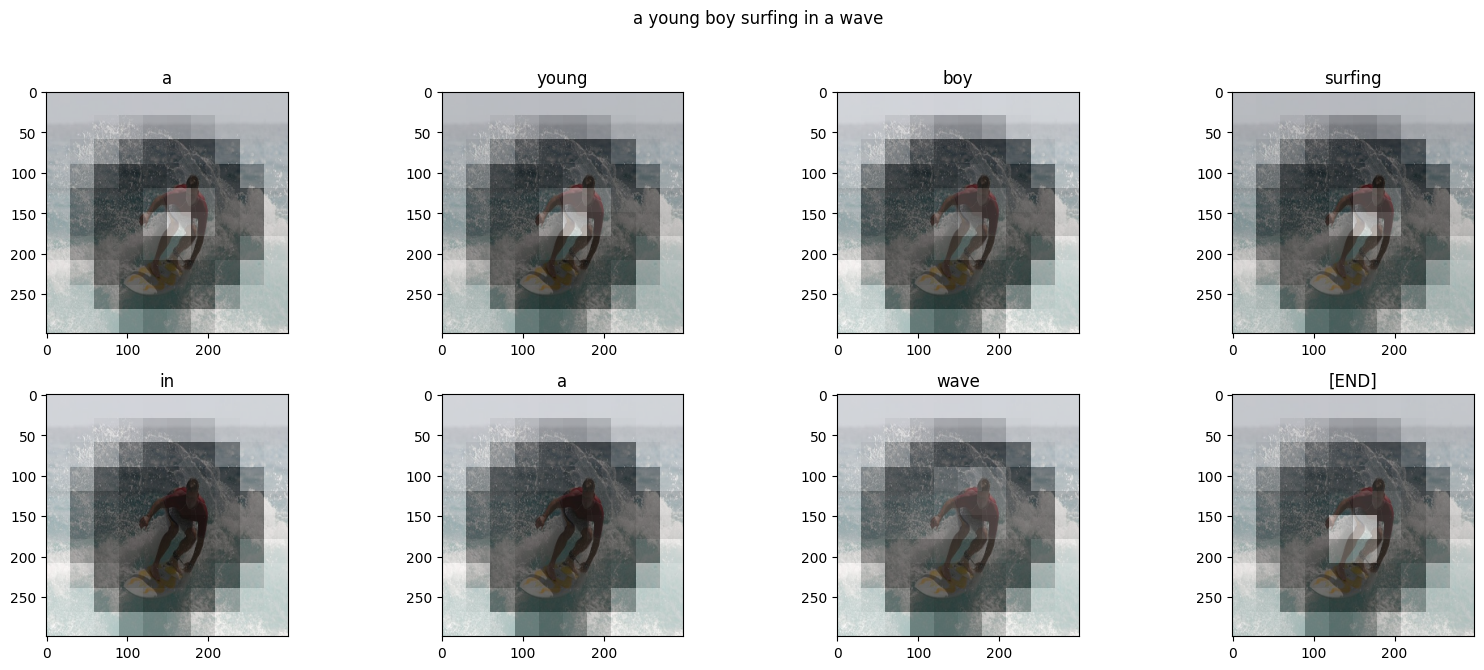

In [79]:
run_and_show_attention(model, image,beam_size=7)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


### Εικόνες με καλά αποτελέσματα

['A racing motorcycle rider has fallen off his bike and is sliding on the ground while another rider is driving behind .', 'There is one person on a motorcycle and one person who has fallen on the ground .', 'There is one person on a racing motorcycle and one person on the ground .', 'Two motorcycle racers on a track , one without his motorcycle .', 'dirt bike racing one guy on ground']
<class 'tensorflow.python.framework.ops.EagerTensor'>


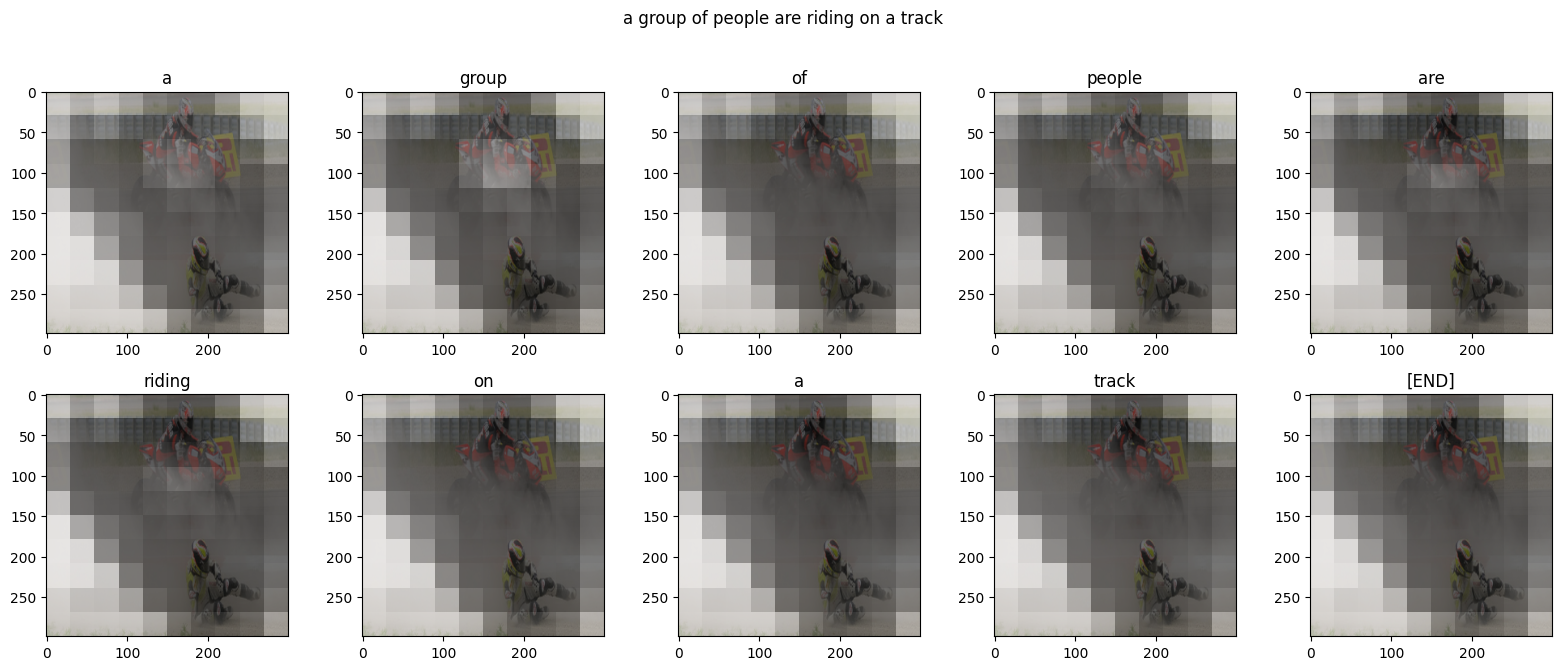

In [109]:
test_paths= test_captions[1258][0]
print(test_captions[1258][1])
image = load_image(test_paths)
run_and_show_attention(model, image,beam_size=3)

['A man wearing suspenders and sunglasses leaps up in the air with his arms and legs spread out to the side .', 'A man wearing suspenders performs a split in midair .', 'A bearded man with glasses does a toe-touch .', 'A man jumps into the air .', 'A man jumping into the air']
<class 'tensorflow.python.framework.ops.EagerTensor'>


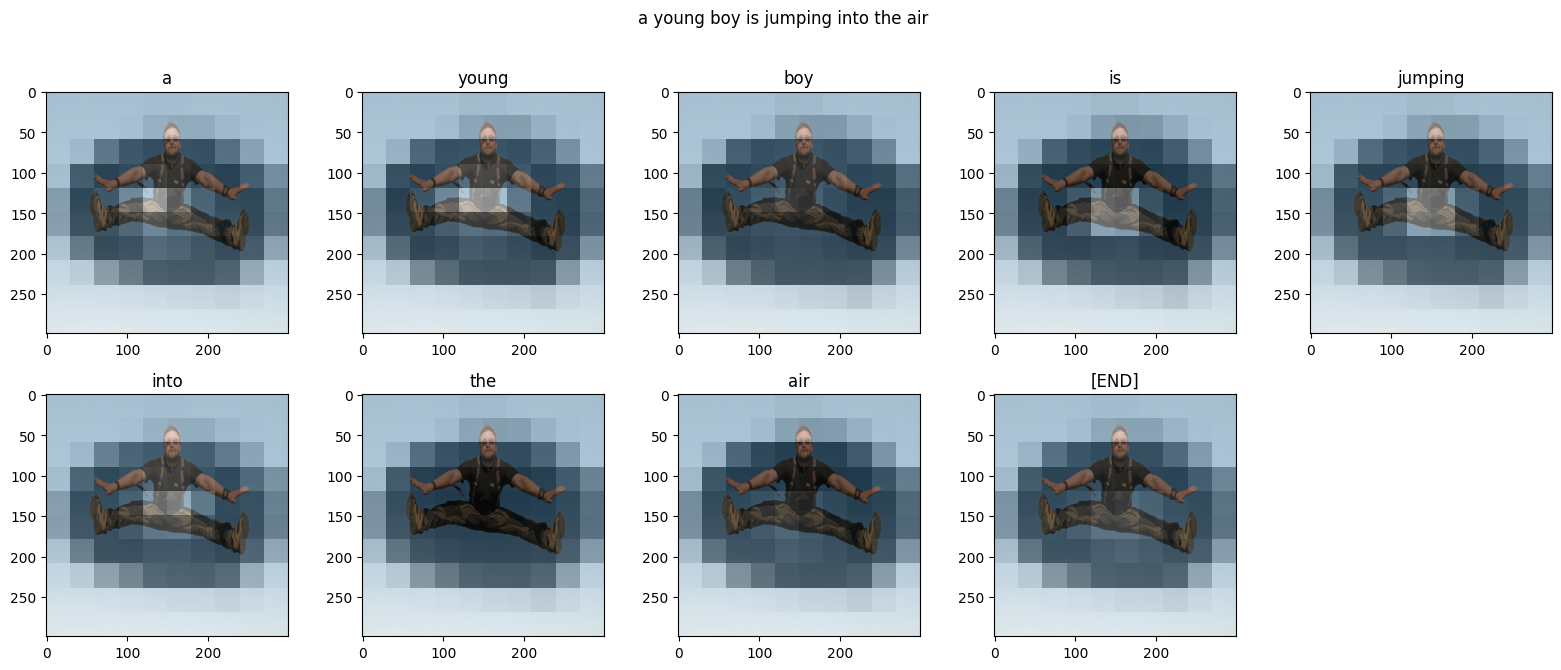

In [101]:
test_paths= test_captions[18][0]
print (test_captions[18][1])
image = load_image(test_paths)
run_and_show_attention(model, image,beam_size=3)

['Two garbage trucks in a parking lot with a man leaning on the front of one of the trucks .', 'Two men standing by two large , green trucks outside of a Family Dollar store .', 'Men standing in front of green trash trucks in a Family Dollar parking lot .', 'Two men standing in front of two green garbage trucks .', 'Two men stand in front of a large green truck .']
<class 'tensorflow.python.framework.ops.EagerTensor'>


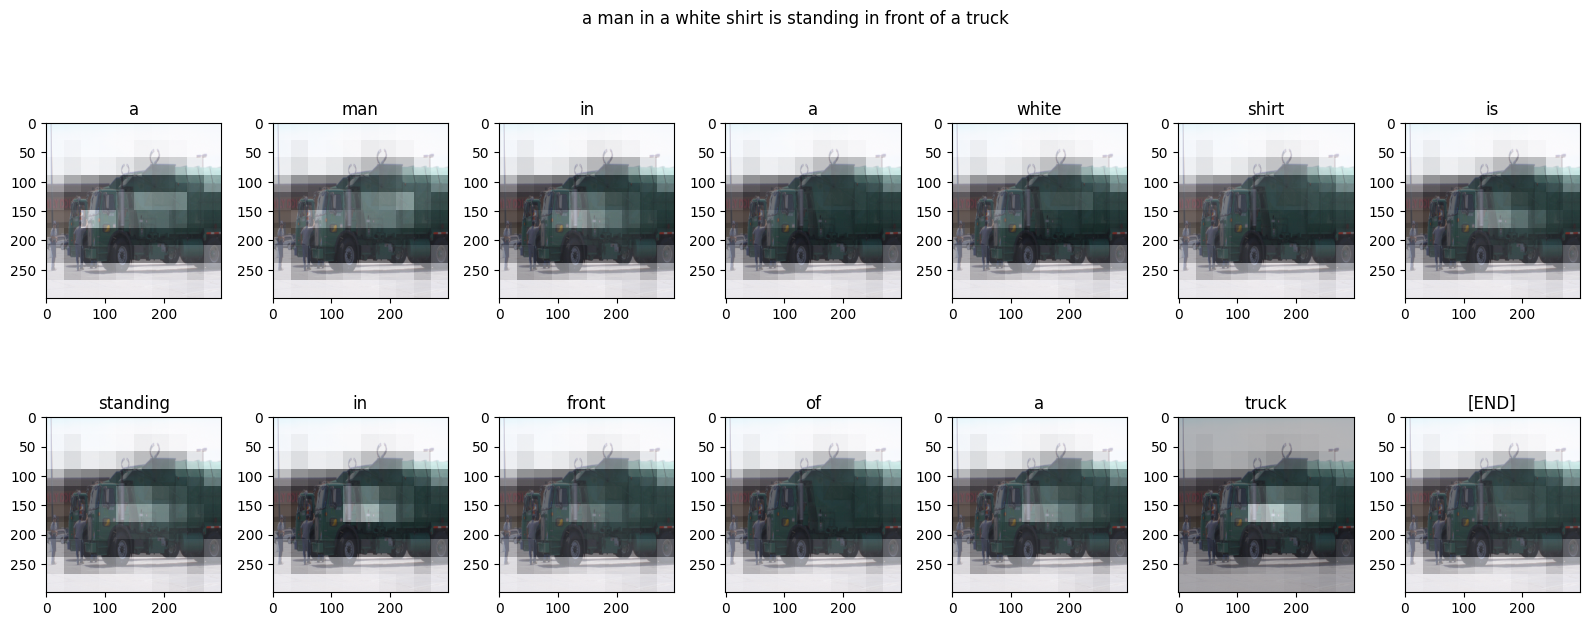

In [110]:
test_paths= test_captions[522][0]
print(test_captions[522][1])
image = load_image(test_paths)
run_and_show_attention(model, image,beam_size=3)

### Εικόνες με κακά αποτελέσματα

<class 'tensorflow.python.framework.ops.EagerTensor'>


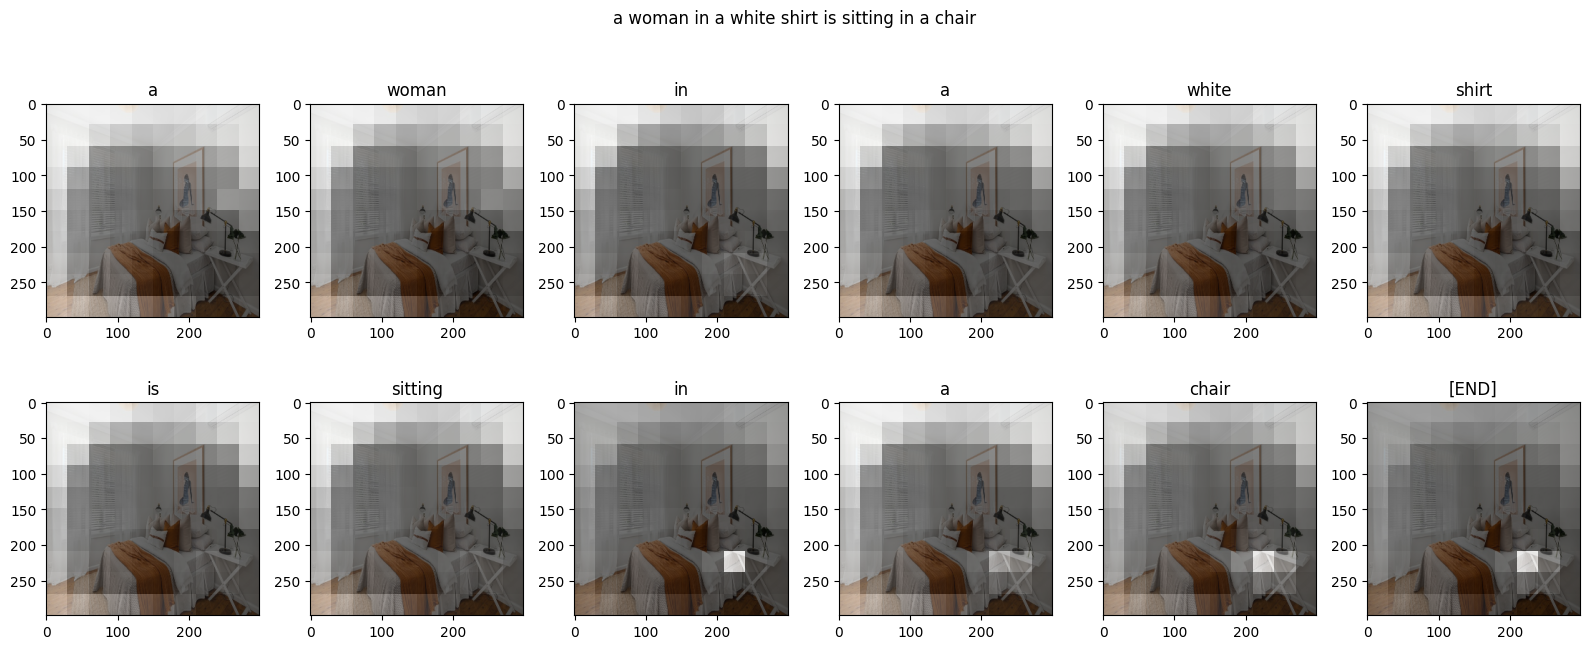

In [81]:

image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image,beam_size=3)

Στην παραπάνω εικόνα παρατηρούμε ότι δεν υπάρχει πουθενά εκτίμηση του χώρου παρά μόνο εστίαση σε λεπτομέρειές του χωρίς πρόβλεψη των αντικειμένων που περιγράφουν (προσπαθεί να αναλύσει τι περιγράφει ο πίνακας μη γνωρίζοντας ότι είναι ένας πίνακας).

['An animal running through the sand at the beach .', 'A brown and black dog runs down a sandy beach .', 'An orange cat with black stripes on a beach .', 'A striped dog runs along the beach .', 'Long necked dog jumps on']
<class 'tensorflow.python.framework.ops.EagerTensor'>


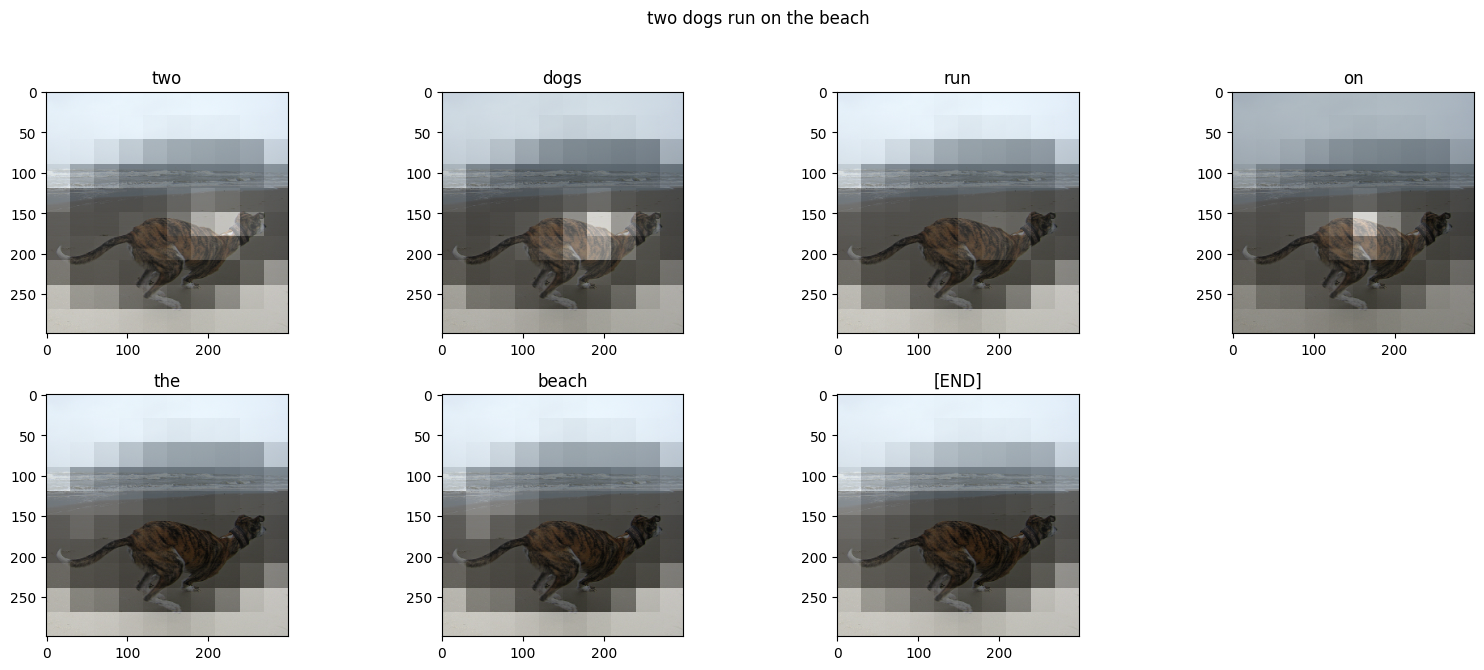

In [108]:
test_paths= test_captions[2560][0]
print(test_captions[2560][1])
image = load_image(test_paths)
run_and_show_attention(model, image,beam_size=3)

Εδώ το μοντέλο έδειξε να είναι αρκετά αποτελεσματικό ως προς την πρόβλεψη της κατάστασης αλλά και πάλι όχι ως προς την εκτίμηση του χώρου (πιστεύει ότι υπάρχουν δύο σκύλοι αντί για έναν)

['A person wearing a mask is welding a metal object which is producing sparks .', 'A man welding with a shield covering his face and protective clothing .', 'A man wearing a welding helmet welding steel .', 'A man in a welding mask welds a girder .', 'A fabricator welds on a steel girder .']
<class 'tensorflow.python.framework.ops.EagerTensor'>


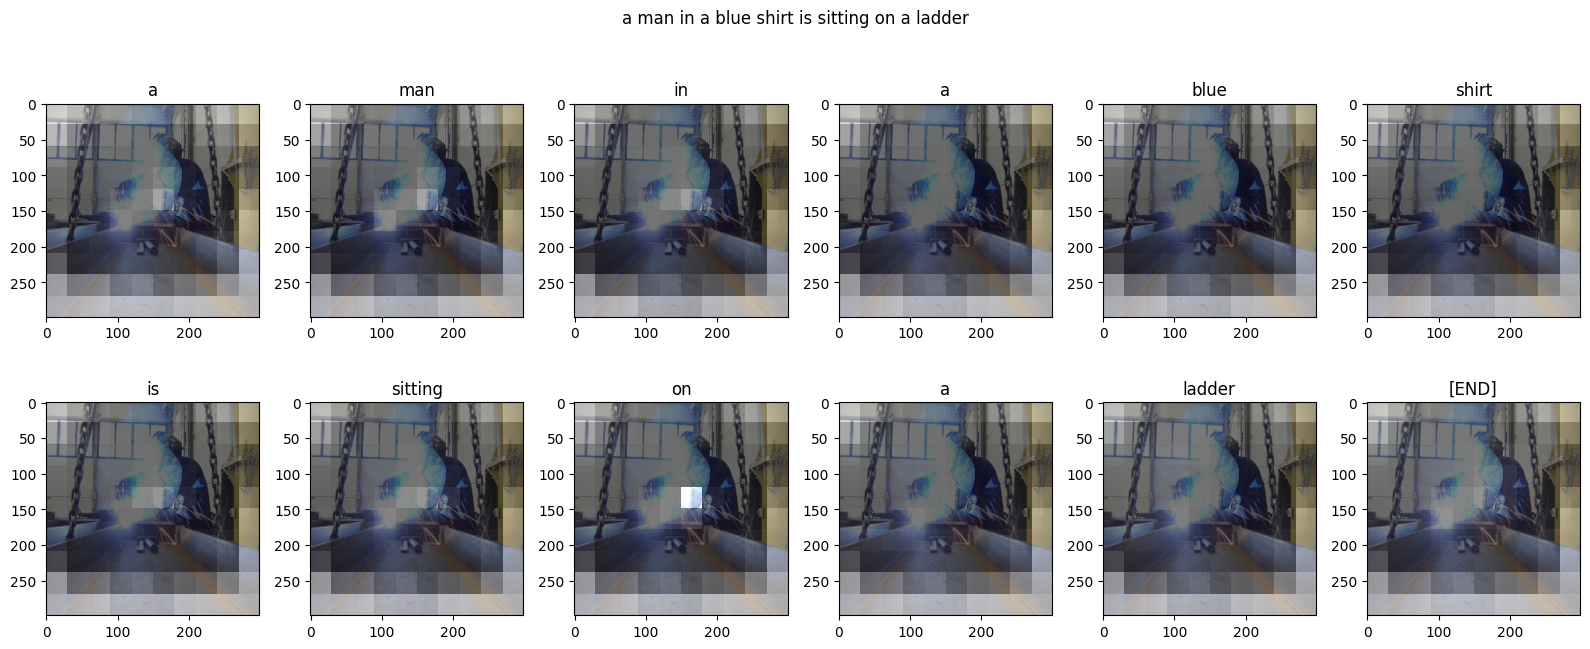

In [115]:
test_paths= test_captions[20][0]
print(test_captions[20][1])
image = load_image(test_paths)
run_and_show_attention(model, image,beam_size=3)

Το μοντέλο στην παραπάνω φωτογραφία δείχνει μία πολύ κακή πρόβλεψη ως προς όλο το σύνολο του χώρου και της κατάστασης που η εικόνα αναπαραστεί.

### Preprocess captions for bleu calculation
Προκειμένου να εκτιμήσουμε την απόδοση του μοντέλου μας χρησιμοποιούμε την μετρική bleu score. Για να την χρησιμοποιήσουμε, επεξεργαζόμαστε το test_set μας με τον ίδιο τρόπο με τον οποίο επεξεργαζόμαστε και το train_set. Αυτό γίνεται με την συνάρτηση preprocess_captions.

In [82]:
import string

def remove_punct_words(words):
    # Create a list of punctuation marks
    punct_marks = set(string.punctuation)
    
    # Use list comprehension to remove words containing only punctuation marks
    return [word for word in words if not all(char in punct_marks for char in word)]


### Corpus BLEU calculation

In [83]:

weights = (0.4, 0.3, 0.2, 0.1)
smoothing_function = bleu_score.SmoothingFunction().method1

def sentence_bleu (path,cap):
    global model
    refs=[word.split(' ')[:-1] for word in cap]
    print(refs)
    image = load_image(path)
    hyp=model.simple_gen(image,temperature=0.0)
    hyp=hyp.split(' ')[:-1]
    print(hyp)
    return bleu_score.sentence_bleu(refs,hyp,weights,smoothing_function)

def corpus_bleu(img_list,beam_size=3):
    hyp = []
    refs = []
    for im,cap in tqdm.tqdm(img_list):
        hyp.append(model.simple_gen(load_image(im),temperature=0.0,beam_size=beam_size).split(' '))
        refs.append([remove_punct_words(word.split(' ')) for word in cap])
    # print(refs)
    #print(hyp)
    return bleu_score.corpus_bleu(refs,hyp,weights=weights,smoothing_function=smoothing_function)

### Compare temperature (greedy) vs. beam search

Από τα παρακάτω παρατηρούμε ότι η πρόβλεψη με βάση το beam search είναι αρκετά πιο αποτελεσματική πάνω στις ίδιες εικόνες αλλά αρκετά πιο αργή ως προς τον χρόνο εκτέλεσης. Παραδείγματα αποτελούν οι 2 παρακάτω υπολογισμοί corpus bleu.

In [84]:
corpus_bleu(test_captions[:10],0)

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


0.1293492161484087

In [85]:
corpus_bleu(test_captions[:10],3)

100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


0.17605071471757183

### Υπολογισμός Bleu Score με Temperature = 0 για 1000 δείγματα

In [91]:
corpus_bleu(test_captions[:1000],0)

100%|██████████| 1000/1000 [18:34<00:00,  1.11s/it]


0.22782497541848798

In [87]:
corpus_bleu(test_captions[:100],0)

100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


0.2508969096215087

## Τελικά Αποτελέσματα
Παρακάτω παρατίθενται τα τελικά αποτελέσματα των δοκιμών μας όπως περιγράφονται στον παρακάτω πίνακα.

| Model | Units | Layers | Heads | Batch Size | Epochs | Learning Rate | Vocabulary Size | Bleu Score |
|:-----:|:-----:|:------:|:-----:|:----------:|:------:|:-------------:|:----------:| :----------:|
| MobileNetV3Small | 512 | 4 | 4 | 32 | 100 | 0.0001 | 10000 | 0.22-0.23 |
| MobileNetV3Large | 512 | 4 | 4 | 32 | 100 | 0.0001 | 7500 | 0.18-0.20 |
| Xception | 512 | 4 | 4 | 32 | 20 | 0.0001 | 10000 | 0.23-0.25 |  
| VGG19 | 512 | 4 | 4 | 32,64 | 30 | 0.0001 | 10000 | 0.20-0.24 |

## Save dataset for the competition


In [88]:
competition_files_list = tf.keras.utils.get_file('competition_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/competition_files.csv',
                                           extract=False)

path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)

competition_files = (path/competition_files_list).read_text().splitlines()
competition_files = [str(path/IMAGE_DIR/fname) for fname in competition_files]

In [89]:
res = []
for img in tqdm.tqdm(competition_files):
  temp_res = model.simple_gen(image=load_image(img),temperature=0,beam_size=0).split()
  res.append(temp_res)

100%|██████████| 500/500 [09:26<00:00,  1.13s/it]


In [90]:
import json 

jsonString = json.dumps(res)
jsonFile = open("test_hypotheses_xception.json", "w")
jsonFile.write(jsonString)
jsonFile.close()